In [ ]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_dir = "/content/drive/MyDrive/Voiseed_task/LibriSpeech"
audio_dir = os.path.join(base_dir, "dev-clean/")
speaker_file = os.path.join(base_dir, "SPEAKERS.TXT")

In [ ]:
speakers_file = "/content/drive/MyDrive/Voiseed_task/LibriSpeech/SPEAKERS.TXT"

with open(speakers_file, "r") as f:
    lines = [line.strip() for line in f.readlines() if not line.startswith(";")]

In [ ]:
speaker_data = []
for line in lines:
    parts = line.split("|")
    speaker_id = parts[0].strip()
    gender = parts[1].strip()
    subset = parts[2].strip()
    speaker_data.append((speaker_id, gender, subset))

df_speakers = pd.DataFrame(speaker_data, columns=["Speaker_ID", "Gender", "Subset"])

df_dev_clean = df_speakers[df_speakers["Subset"] == "dev-clean"]

df_male = df_dev_clean[df_dev_clean["Gender"] == "M"].head(9)
df_female = df_dev_clean[df_dev_clean["Gender"] == "F"].head(9)

df_sampled = pd.concat([df_male, df_female]).reset_index(drop=True)

display(df_sampled)

,Speaker_ID,Gender,Subset
0,174,M,dev-clean
1,251,M,dev-clean
2,422,M,dev-clean
3,652,M,dev-clean
4,777,M,dev-clean
5,1272,M,dev-clean
6,2078,M,dev-clean
7,2086,M,dev-clean
8,2428,M,dev-clean
9,84,F,dev-clean


In [ ]:
audio_dir = "/content/drive/MyDrive/Voiseed_task/LibriSpeech/dev-clean"

n_mfcc = 13
sr = 16000

def extract_mfcc(file_path, n_mfcc=n_mfcc, sr=sr):
    w, sr = librosa.load(file_path, sr=sr)
    print(f"sonor wave: {w},sr{sr}")
    mfccs = librosa.feature.mfcc(y=w, sr=sr, n_mfcc=n_mfcc)
    print(f"mfccs{mfccs}")
    return np.mean(mfccs, axis=1)

In [ ]:
features = []
labels = []

for _, row in df_sampled.iterrows():
    speaker_id = row["Speaker_ID"]
    gender = row["Gender"]
    speaker_folder = os.path.join(audio_dir, str(speaker_id))

    for chapter in os.listdir(speaker_folder):
        chapter_folder = os.path.join(speaker_folder, chapter)

        for file in os.listdir(chapter_folder):
            if file.endswith(".flac"):
                file_path = os.path.join(chapter_folder, file)
                mfcc = extract_mfcc(file_path, n_mfcc=n_mfcc)
                features.append(mfcc)
                labels.append(gender)

print(labels[:10])
X = np.array(features)
y = np.array(labels)

print(f"Extracted MFCC features shape: {X.shape}, Labels shape: {y.shape}")

Output streaming troncato alle ultime 5000 righe.
 [  -2.1627238   -3.2728796   -4.9028378 ...    6.056897     6.57601
     6.330537 ]
 [   7.0703387   13.455551    15.286632  ...    5.4342318    5.836562
     4.9576235]
 [   2.836505     5.3072014    5.633703  ...    4.975555     5.2921
     3.7561214]]
sonor wave: [0.00061035 0.00015259 0.00021362 ... 0.00036621 0.00048828 0.00057983],sr16000
mfccs[[-579.7244    -577.0721    -575.1368    ... -581.0946    -582.33685
  -580.56964  ]
 [  21.27661     24.110653    25.45703   ...   19.519386    17.95385
    19.856041 ]
 [  19.002764    20.1683      19.21545   ...   18.075603    16.816635
    17.754925 ]
 ...
 [  12.78932     11.13577     11.190034  ...    8.834368     9.6016655
    11.001677 ]
 [  11.234392    10.096746    10.899759  ...    8.396988     8.606869
     9.183073 ]
 [   8.509922     8.22445      9.117035  ...    7.616667     7.401723
     7.019752 ]]
sonor wave: [-6.1035156e-05  3.0517578e-05 -1.5258789e-04 ... -2.4414062e-04

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
print(X_scaled)

[[-1.9549223   0.481964   -0.84539825 ... -1.0826141  -2.245857
  -0.7524722 ]
 [-1.0327951   0.08165001 -0.91690344 ... -0.99308306 -2.0743291
  -0.49862573]
 [-2.8418021  -0.10245834 -0.05701597 ...  0.19750293 -1.7005142
  -0.06125935]
 ...
 [-0.15255123  2.199865   -0.7911116  ...  1.632979    0.16459174
   1.175053  ]
 [ 0.40658808  2.373193   -0.6909798  ...  0.7862521  -0.3637281
   0.79762286]
 [-0.39976797  1.9145877  -0.39215833 ...  0.7150547  -0.5058155
   1.1034797 ]]


In [ ]:
X_scaled.shape

(349, 13)

**Feature distribution**

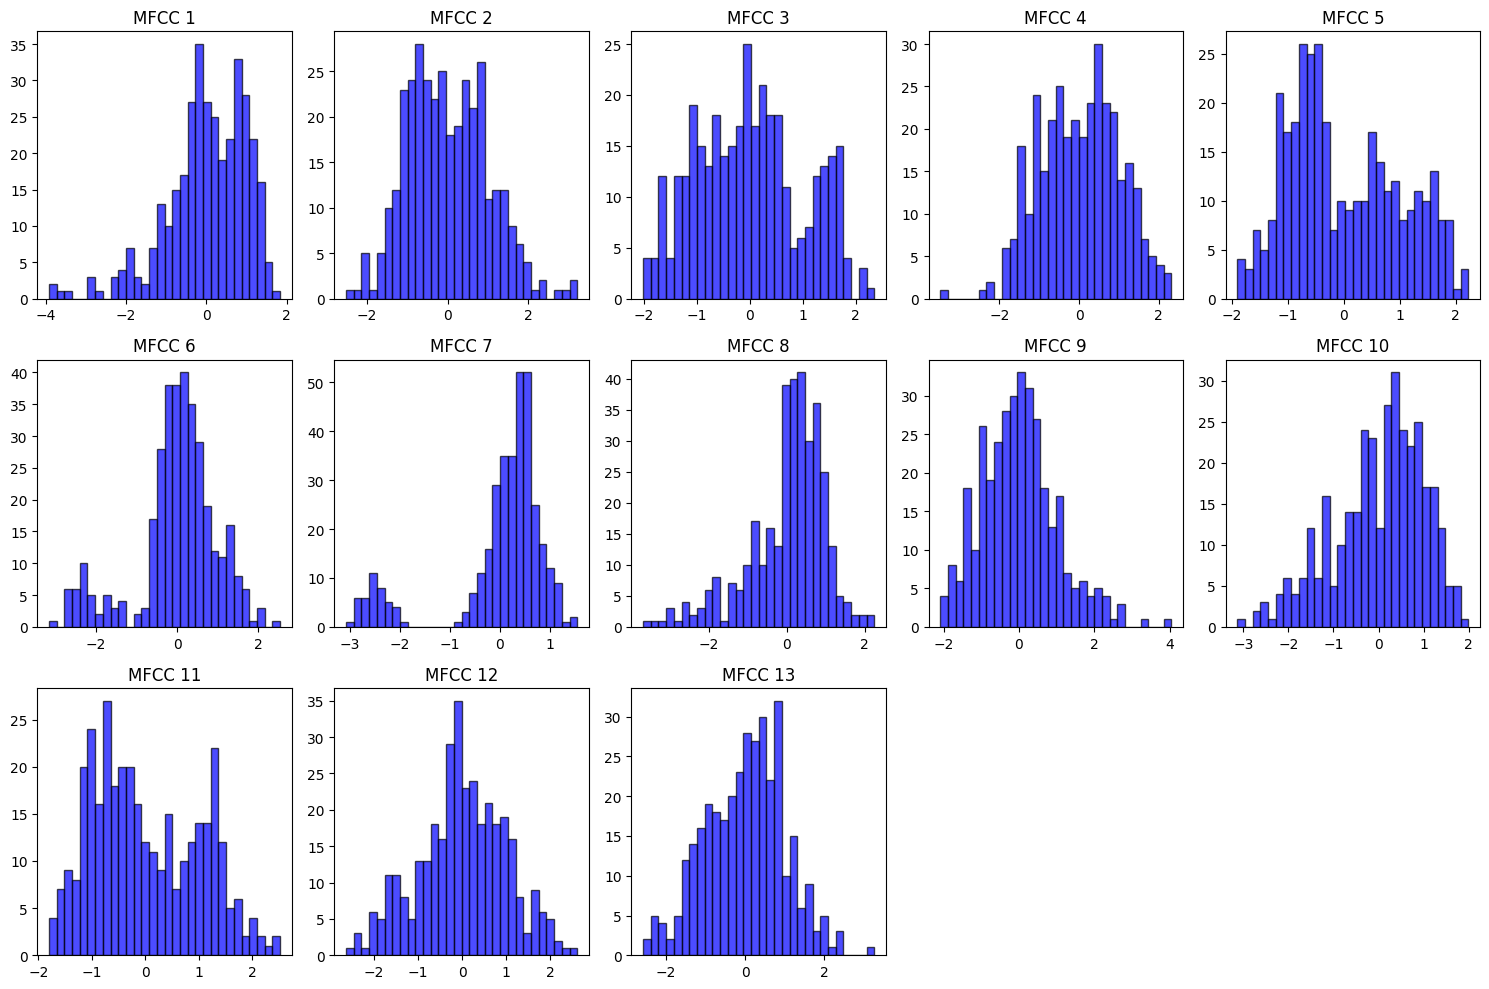

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    plt.hist(X_scaled[:, i], bins=30, alpha=0.7, color='b', edgecolor='black')
    plt.title(f'MFCC {i+1}')
plt.tight_layout()
plt.show()

**Boxplot to identify outliers**

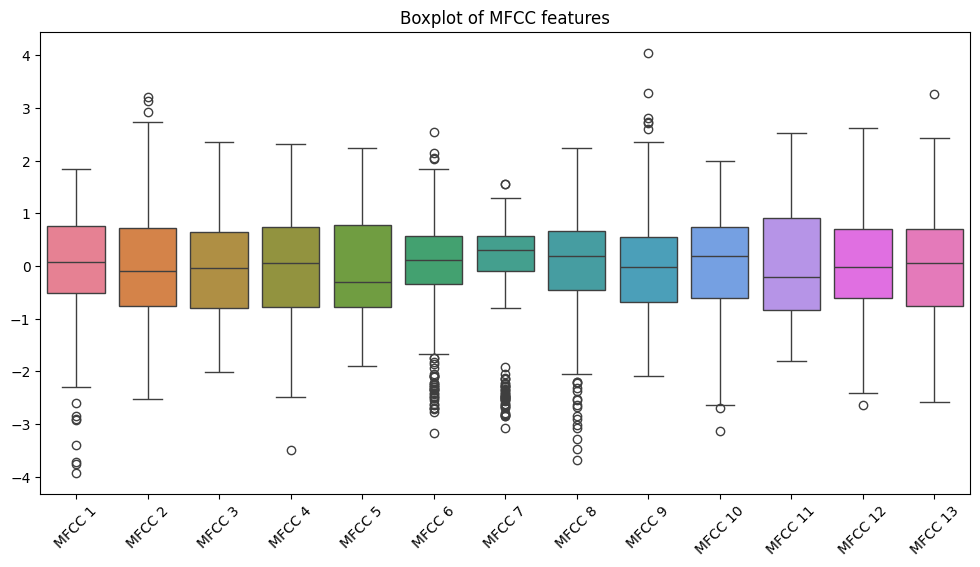

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled)
plt.xticks(range(13), [f'MFCC {i+1}' for i in range(13)], rotation=45)
plt.title("Boxplot of MFCC features")
plt.show()

**Analysis of the correlation between MFCC and gender**

In [ ]:
df_mfcc = pd.DataFrame(X_scaled, columns=[f'MFCC {i+1}' for i in range(13)])
df_mfcc["Gender"] = y

In [ ]:
print(df_mfcc)

       MFCC 1    MFCC 2    MFCC 3    MFCC 4    MFCC 5    MFCC 6    MFCC 7  \
0   -1.954922  0.481964 -0.845398 -0.893183 -1.097527  1.045647  0.340232   
1   -1.032795  0.081650 -0.916903 -1.307150 -1.039843  1.457469  0.199822   
2   -2.841802 -0.102458 -0.057016 -0.777272 -0.012303  1.836113  0.700816   
3   -1.966681  1.373513 -1.164926 -2.163619 -1.067636  1.565937  0.500838   
4   -2.294826  0.281051 -0.517309 -1.136344 -0.815523  1.178424  0.384622   
..        ...       ...       ...       ...       ...       ...       ...   
344 -0.174921  1.434482 -1.016539  1.128807 -0.274332  0.875113  0.489579   
345 -0.129511  1.748617 -0.987569  2.150723 -0.872740  0.711284  0.605808   
346 -0.152551  2.199865 -0.791112  1.188228 -0.462065  1.627337  0.904343   
347  0.406588  2.373193 -0.690980  0.790904 -1.809055  1.189819  0.783867   
348 -0.399768  1.914588 -0.392158  1.484380 -0.353197  0.826903  0.738229   

       MFCC 8    MFCC 9   MFCC 10   MFCC 11   MFCC 12   MFCC 13 Gender  
0 

In [ ]:
summary_stats = df_mfcc.groupby("Gender").agg(["mean", "std"])

In [ ]:
print(summary_stats.iloc[:,:14])
print(summary_stats.iloc[:,14:])

          MFCC 1              MFCC 2              MFCC 3              MFCC 4  \
            mean       std      mean       std      mean       std      mean   
Gender                                                                         
F       0.112695  0.903523  0.107379  1.067150 -0.262761  0.758613  0.580456   
M      -0.185264  1.123588 -0.176525  0.857843  0.431964  1.188625 -0.954235   

                    MFCC 5              MFCC 6             MFCC 7            
             std      mean       std      mean       std     mean       std  
Gender                                                                       
F       0.691648 -0.210528  0.686001 -0.339652  1.013001 -0.31239  1.129933  
M       0.632228  0.346096  1.301560  0.558367  0.683273  0.51355  0.362695  
          MFCC 8              MFCC 9             MFCC 10             MFCC 11  \
            mean       std      mean       std      mean       std      mean   
Gender                                           

**distribution of MFCCs by gender**

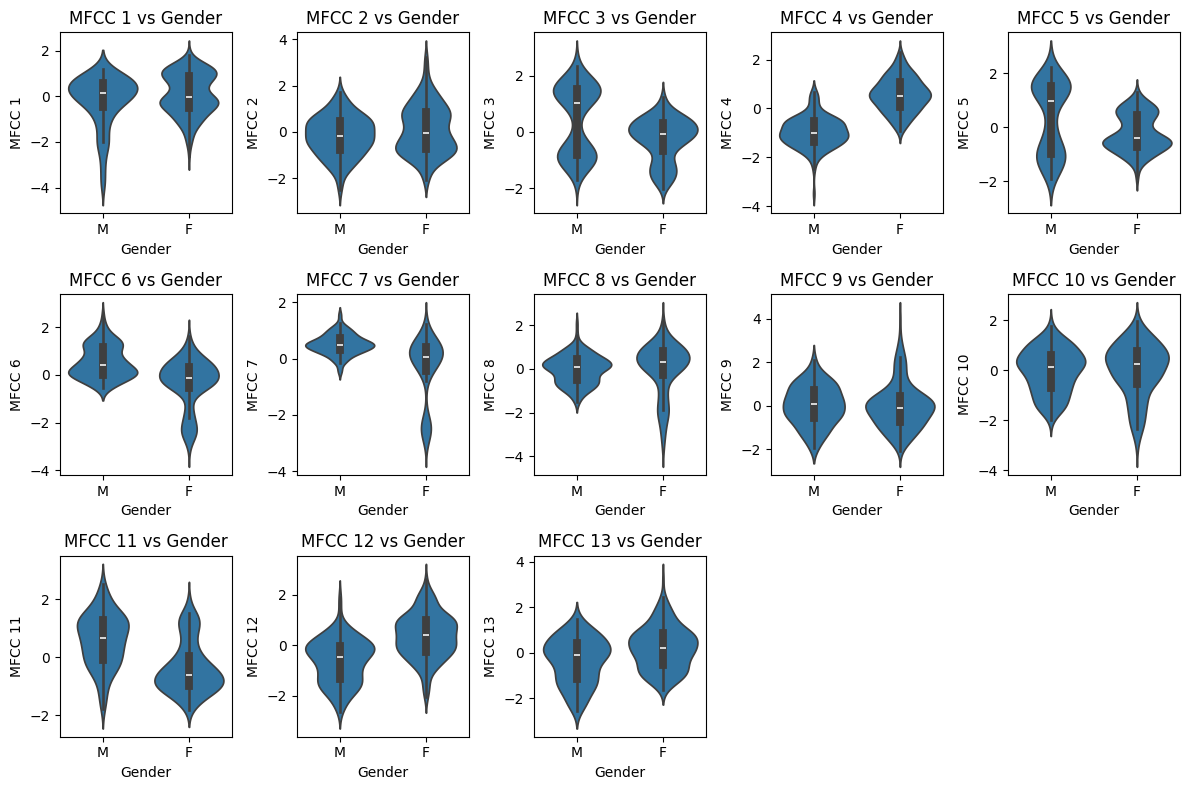

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(13):
    plt.subplot(3, 5, i + 1)
    sns.violinplot(x="Gender", y=f"MFCC {i+1}", data=df_mfcc)
    plt.title(f'MFCC {i+1} vs Gender')
plt.tight_layout()
plt.show()

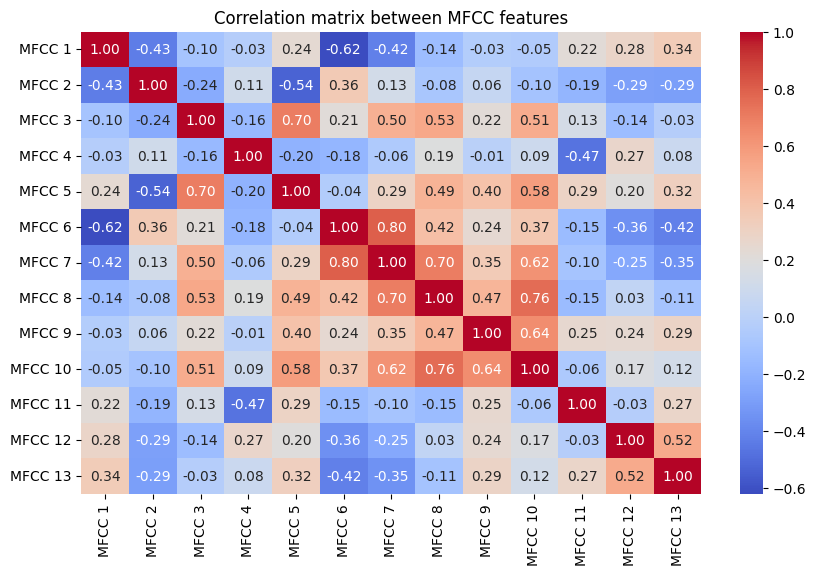

In [ ]:
plt.figure(figsize=(10, 6))
corr_matrix = df_mfcc.iloc[:, :-1].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix between MFCC features")
plt.show()

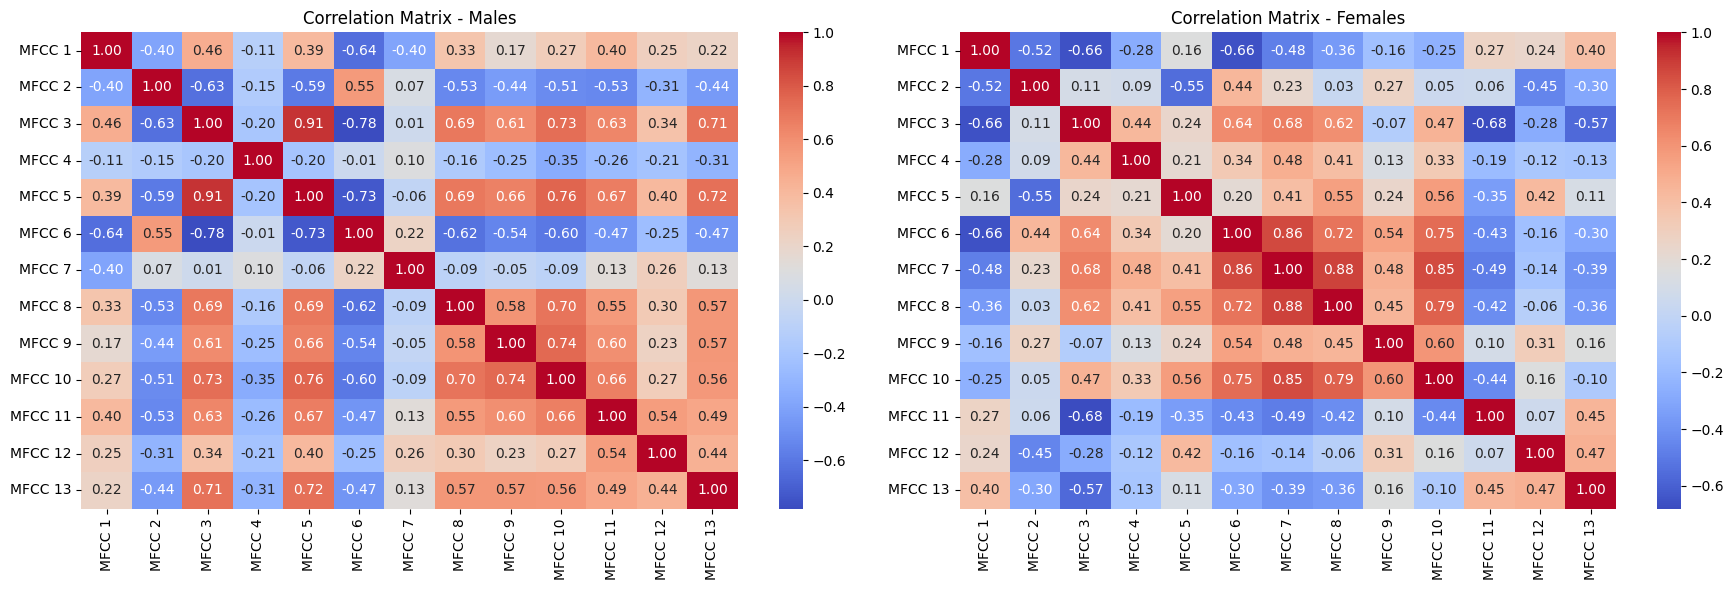

In [ ]:
corr_matrix_male = df_mfcc[df_mfcc["Gender"] == "M"].iloc[:, :-1].corr()
corr_matrix_female = df_mfcc[df_mfcc["Gender"] == "F"].iloc[:, :-1].corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(corr_matrix_male, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
axes[0].set_title("Correlation Matrix - Males")

sns.heatmap(corr_matrix_female, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
axes[1].set_title("Correlation Matrix - Females")

plt.tight_layout()
plt.show()

In [ ]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)
print(y, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M' 'M' 'M' 'M' 'M' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F

## Models

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (279, 13), Test set: (70, 13)


**Naïve baseline → Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

**Sophisticated baseline → Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

**Neural Network (MLP) → Multi-Layer Perceptron**

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", max_iter=500)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

**Deep Learning Model (CNN) → Convolutional Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X_train_cnn = X_train.reshape(X_train.shape[0], 13, 1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 13, 1, 1)

cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 1), activation='relu', input_shape=(13, 1, 1)),
    layers.MaxPooling2D((2, 1)),
    layers.Conv2D(64, (3, 1), activation='relu'),
    layers.MaxPooling2D((2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.6256 - loss: 0.6774 - val_accuracy: 0.8000 - val_loss: 0.6099
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8233 - loss: 0.5976 - val_accuracy: 0.8857 - val_loss: 0.5241
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8821 - loss: 0.5053 - val_accuracy: 0.9286 - val_loss: 0.4282
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9664 - loss: 0.3903 - val_accuracy: 0.9429 - val_loss: 0.3257
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9732 - loss: 0.2919 - val_accuracy: 0.9429 - val_loss: 0.2407
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9546 - loss: 0.2137 - val_accuracy: 0.9714 - val_loss: 0.1706
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9781 - loss: 0.1422 - val_accuracy: 0.9714 - val_loss: 0.1271
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9839 - loss: 0.1007 - val_accuracy: 0.9714 - val_loss: 0.0994
Epo

**REPORT**

In [ ]:
from sklearn.metrics import classification_report

report_log_reg = classification_report(y_test, y_pred_log, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
report_cnn = classification_report(y_test, y_pred_cnn, output_dict=True)

df_log_reg = pd.DataFrame(report_log_reg).transpose()
df_svm = pd.DataFrame(report_svm).transpose()
df_mlp = pd.DataFrame(report_mlp).transpose()
df_cnn = pd.DataFrame(report_cnn).transpose()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


In [ ]:
print("Logistic Regression Report:\n", df_log_reg)
print("\nSVM Report:\n", df_svm)

Logistic Regression Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0     44.0
1                   1.0     1.0       1.0     26.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0

SVM Report:
               precision    recall  f1-score    support
0              1.000000  0.977273  0.988506  44.000000
1              0.962963  1.000000  0.981132  26.000000
accuracy       0.985714  0.985714  0.985714   0.985714
macro avg      0.981481  0.988636  0.984819  70.000000
weighted avg   0.986243  0.985714  0.985767  70.000000


In [ ]:
print("\nMLP Report:\n", df_mlp)
print("\nCNN Report:\n", df_cnn)


MLP Report:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0     44.0
1                   1.0     1.0       1.0     26.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     70.0
weighted avg        1.0     1.0       1.0     70.0

CNN Report:
               precision    recall  f1-score    support
0              1.000000  0.977273  0.988506  44.000000
1              0.962963  1.000000  0.981132  26.000000
accuracy       0.985714  0.985714  0.985714   0.985714
macro avg      0.981481  0.988636  0.984819  70.000000
weighted avg   0.986243  0.985714  0.985767  70.000000


In [ ]:
import pickle
file_path = "/content/drive/MyDrive/Voiseed_task/df_sampled.pkl"
with open(file_path, "wb") as f:
    pickle.dump(df_sampled, f)

# Part 2

In [ ]:
import librosa
import numpy as np
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
with open(file_path, "rb") as f:
    df_sampled = pickle.load(f)
print(df_sampled.head())

  Speaker_ID Gender     Subset
0        174      M  dev-clean
1        251      M  dev-clean
2        422      M  dev-clean
3        652      M  dev-clean
4        777      M  dev-clean


In [ ]:
def extract_wav2vec_features(file_path, model, processor, chunk_duration=2.0, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)

    chunk_size = int(sr * chunk_duration)
    chunks = [y[i:i+chunk_size] for i in range(0, len(y), chunk_size) if len(y[i:i+chunk_size]) == chunk_size]
    features = []
    for chunk in chunks:
        inputs = processor(chunk, return_tensors="pt", sampling_rate=sr).input_values.to(device)

        with torch.no_grad():
            embeddings = model(inputs).last_hidden_state.mean(dim=1).cpu().numpy()

        features.append(embeddings.flatten())

    return np.array(features)
features = []
labels = []

In [ ]:
for _, row in df_sampled.iterrows():
    speaker_id = row["Speaker_ID"]
    speaker_label = speaker_id

    speaker_folder = os.path.join(audio_dir, str(speaker_id))

    for chapter in os.listdir(speaker_folder):
        chapter_folder = os.path.join(speaker_folder, chapter)

        for file in os.listdir(chapter_folder):
            if file.endswith(".flac"):
                audio_file_path = os.path.join(chapter_folder, file)
                emb = extract_wav2vec_features(audio_file_path, model, processor)

                for e in emb:
                    features.append(e)
                    labels.append(speaker_label)

X = np.array(features)
y = np.array(labels)

print(f"Extracted Features Shape: {X.shape}, Labels Shape: {y.shape}")

Extracted Features Shape: (3309, 768), Labels Shape: (3309,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (2647, 768), Test set: (662, 768)


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# SVM
svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\nRandom Forest:\n", classification_report(y_test, y_pred_rf))
print("\nSVM:\n", classification_report(y_test, y_pred_svm))


Random Forest:
               precision    recall  f1-score   support

        1272       1.00      0.95      0.97       122
        1462       1.00      1.00      1.00       122
        1673       0.98      1.00      0.99       133
         174       0.95      0.95      0.95       131
        1919       0.98      1.00      0.99       127
        1988       1.00      1.00      1.00        27

    accuracy                           0.98       662
   macro avg       0.98      0.98      0.98       662
weighted avg       0.98      0.98      0.98       662


SVM:
               precision    recall  f1-score   support

        1272       0.74      0.79      0.76       122
        1462       0.71      0.80      0.75       122
        1673       0.79      0.80      0.80       133
         174       0.67      0.69      0.68       131
        1919       0.78      0.72      0.75       127
        1988       1.00      0.22      0.36        27

    accuracy                           0.74       662

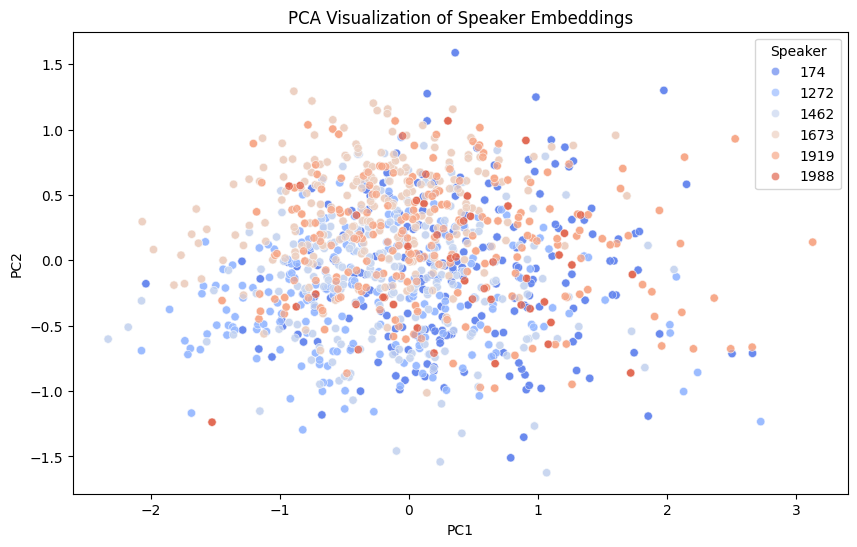

In [ ]:
# Reduction to 2 main components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Speaker"] = y

# Visualization PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Speaker", palette="coolwarm", data=df_pca, alpha=0.7)
plt.title("PCA Visualization of Speaker Embeddings")
plt.show()


Github Repo

In [91]:
%cd /content/drive/MyDrive/
!git clone https://github.com/LosaLosSantos/Speaker-Classification.git

/content/drive/MyDrive
Cloning into 'Speaker-Classification'...


In [94]:
%cd /content/drive/MyDrive/Speaker-Classification

/content/drive/MyDrive/Speaker-Classification


In [92]:
import shutil

source_dir = "/content/drive/MyDrive/Voiseed_task/"
repo_dir = "/content/drive/MyDrive/Speaker-Classification/"

shutil.copy(source_dir + "DSP.ipynb", repo_dir + "DSP.ipynb")
shutil.copy(source_dir + "df_sampled.pkl", repo_dir + "df_sampled.pkl")
shutil.copy(source_dir + "LibriSpeech/SPEAKERS.TXT", repo_dir + "SPEAKERS.TXT")

'/content/drive/MyDrive/Speaker-Classification/SPEAKERS.TXT'

In [100]:
!git add .
!git commit -m "1"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [101]:
!git push origin main

Everything up-to-date
